<a href="https://colab.research.google.com/github/amin1nasim/TAing601_Computer_Vision/blob/main/Week9/Positional_Embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Torch
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


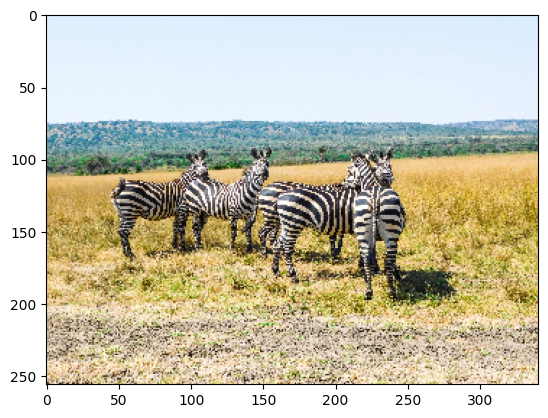

In [ ]:
size = 256

original_img = Image.open('zibra.jpg')
img = transforms.ToTensor()(original_img)
img = transforms.Resize(size,)(img)
img = img.permute(1, 2, 0)
plt.imshow(img)
plt.show()

In [ ]:
indices = torch.meshgrid(torch.arange(img.shape[0]), torch.arange(img.shape[1]))
indices = torch.stack(indices, axis=-1).reshape(-1, 2).to(device).float()
rgbs = img.clone().reshape(-1, 3).to(device)

/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
model_no_embedding_fn = lambda : torch.nn.Sequential(
    torch.nn.Linear(2, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 3),
    torch.nn.Sigmoid(),
    )

In [ ]:
model = model_no_embedding_fn().to(device)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Epoch: 1, Loss: 0.1820160299539566


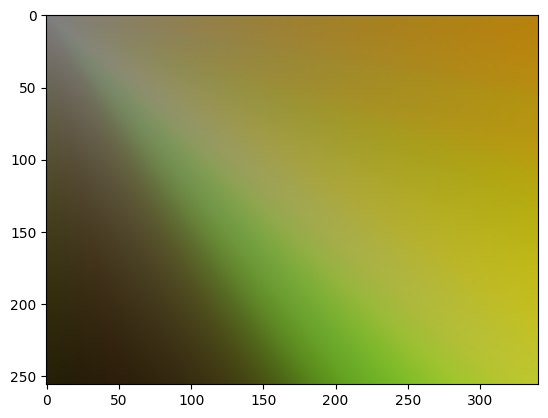

Epoch: 1000, Loss: 0.03737296536564827


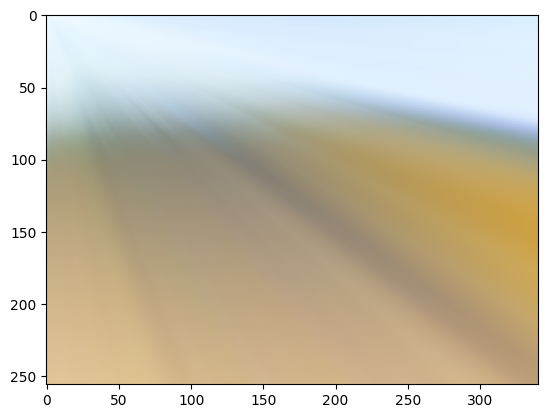

Epoch: 2000, Loss: 0.03459285944700241


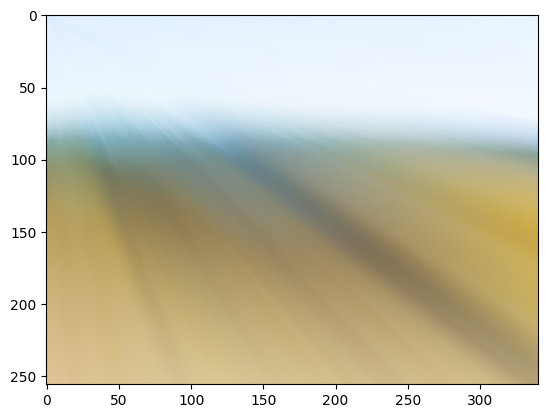

Epoch: 3000, Loss: 0.032254502177238464


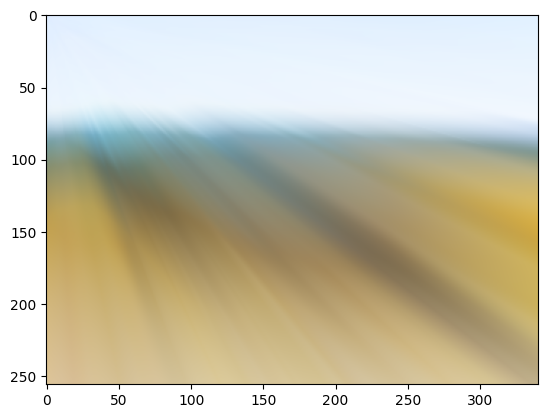

Epoch: 4000, Loss: 0.03061814047396183


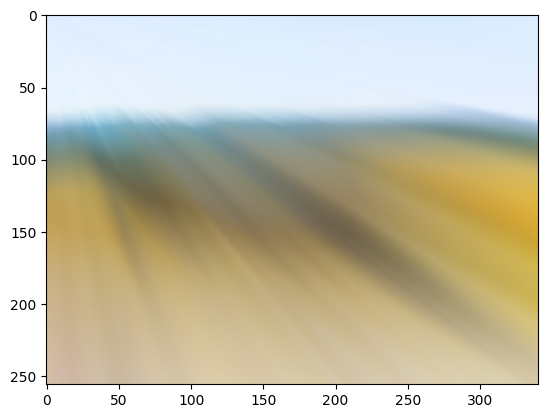

Epoch: 5000, Loss: 0.03125740587711334


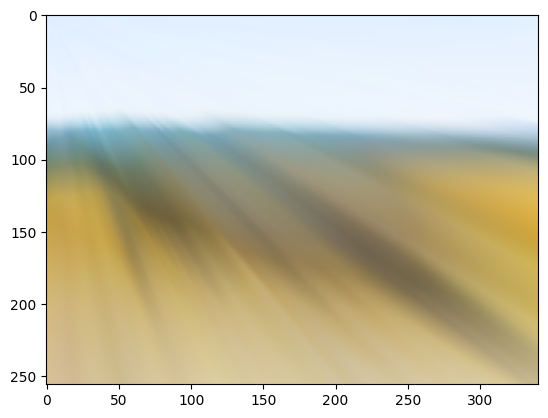

Epoch: 6000, Loss: 0.031446631997823715


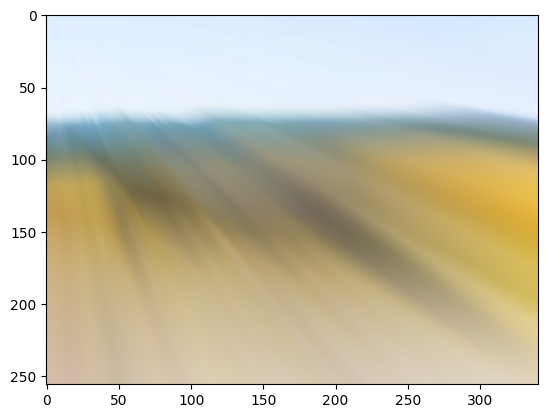

Epoch: 7000, Loss: 0.029164845123887062


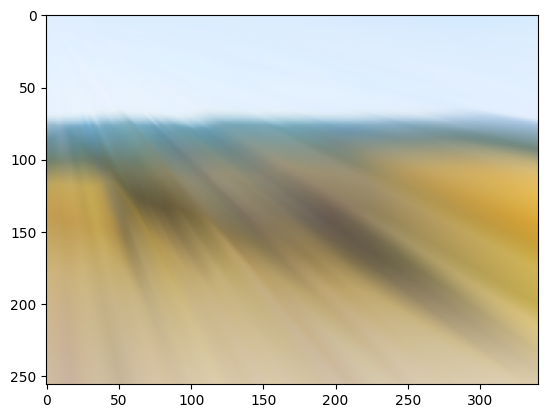

Epoch: 8000, Loss: 0.029209041967988014


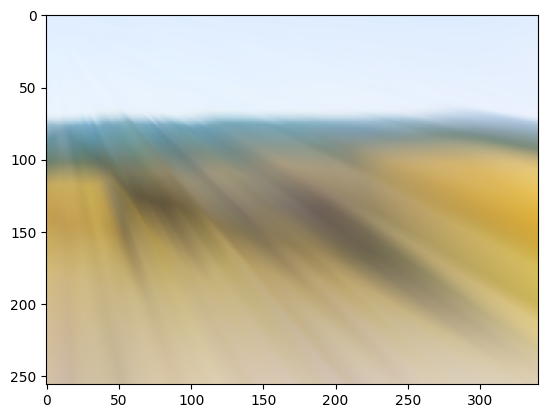

Epoch: 9000, Loss: 0.028931360691785812


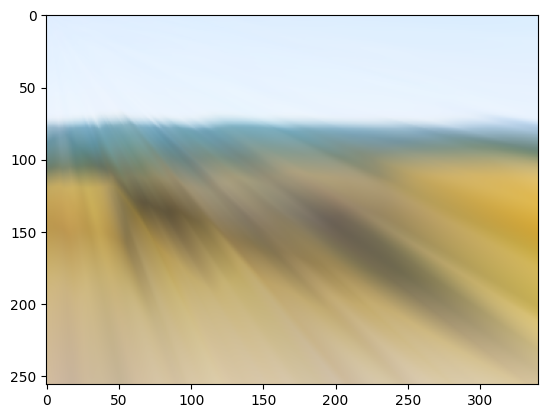

Epoch: 10000, Loss: 0.029735976830124855


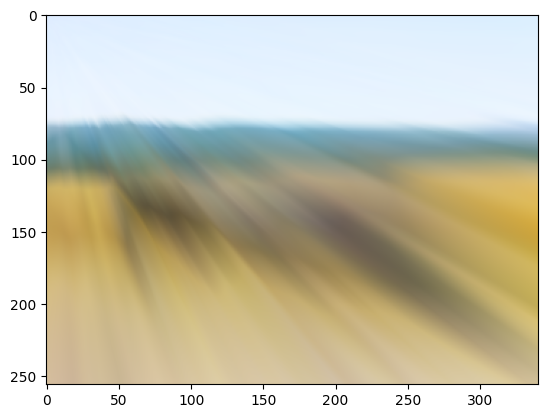

In [ ]:
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()
    pred_rgbs = model(indices)
    loss = loss_fn(pred_rgbs, rgbs)
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 999 or epoch == 0:
        with torch.no_grad():
            pred_img = pred_rgbs.reshape(img.shape)
            print(f"Epoch: {epoch + 1}, Loss: {loss}")
            plt.imshow(pred_img.cpu())
            plt.show()


In [ ]:
class Embedder():
    def __init__(self, num_freqs, max_freq_log2,
                 input_dims=2, include_input=True, periodic_fns=[torch.sin, torch.cos]):
        self.kwargs = dict(num_freqs=num_freqs, max_freq_log2=max_freq_log2,
                          input_dims=input_dims, include_input=include_input,
                          periodic_fns=periodic_fns)
        self.create_embedding_fn()
    
    def create_embedding_fn(self):
        embed_fns = []
        d = self.kwargs['input_dims']
        out_dim = 0
        if self.kwargs['include_input']:
            embed_fns.append(lambda x: x)
            out_dim += d
        max_freq = self.kwargs['max_freq_log2']
        N_freq = self.kwargs['num_freqs']
        
        freq_bands = 2.**torch.linspace(0., max_freq, steps=N_freq)

        for freq in freq_bands:
            for p_fn in self.kwargs['periodic_fns']:
                embed_fns.append(lambda x, p_fn=p_fn, freq=freq: p_fn(freq * x))
                out_dim += d
        self.embed_fns = embed_fns
        self.out_dim = out_dim
        
    def embed(self, inputs):
        return torch.cat([fn(inputs) for fn in self.embed_fns], -1)
    def __call__(self, x):
        return self.embed(x)

In [ ]:
embedder = Embedder(num_freqs=9, max_freq_log2=8)
model_with_embedding_fn = lambda : torch.nn.Sequential(
    torch.nn.Linear(embedder.out_dim, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 3),
    torch.nn.Sigmoid(),
    )

In [ ]:
model = model_with_embedding_fn().to(device)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch: 1, Loss: 0.11343113332986832


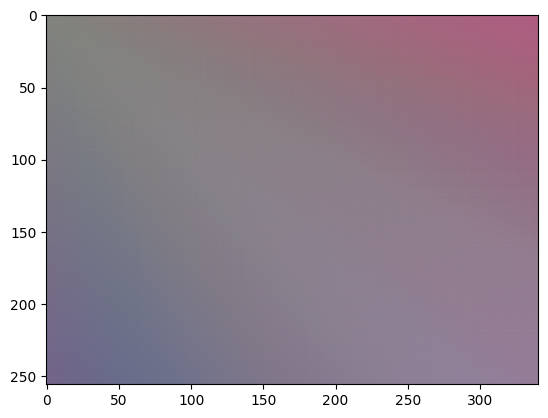

Epoch: 1000, Loss: 0.022706929594278336


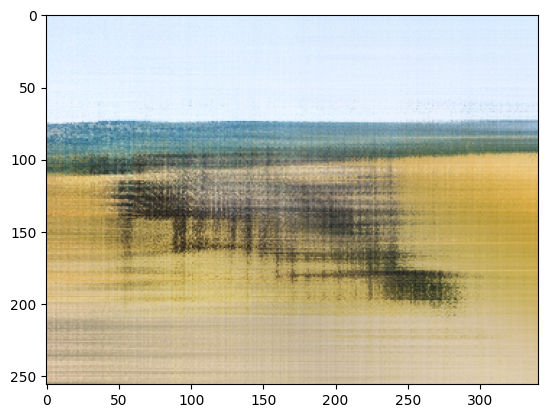

Epoch: 2000, Loss: 0.015811510384082794


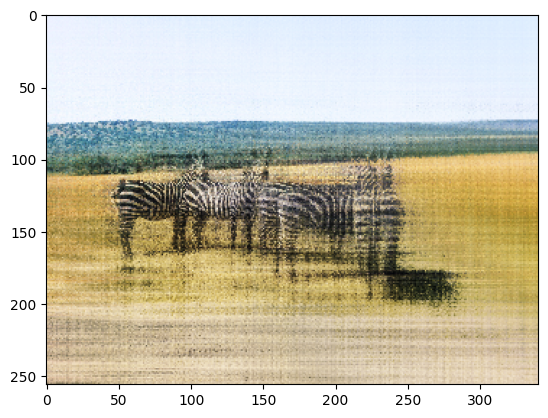

Epoch: 3000, Loss: 0.009254489094018936


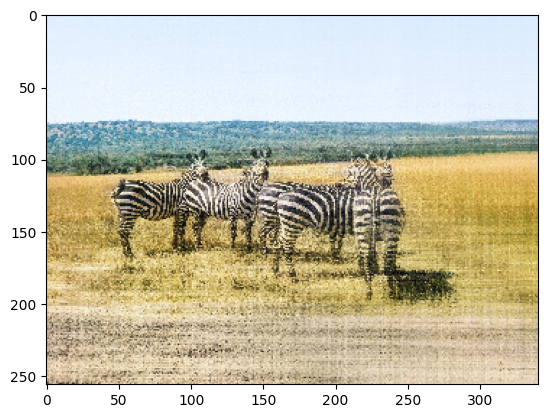

Epoch: 4000, Loss: 0.00654592365026474


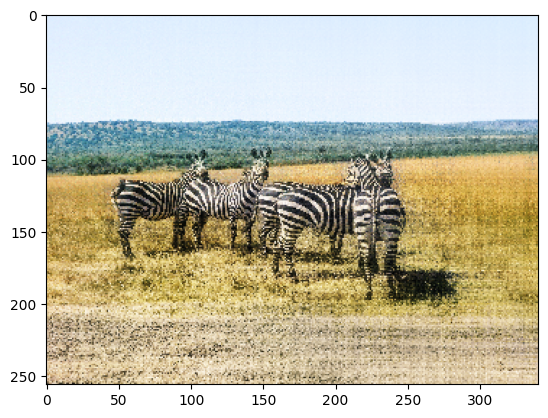

Epoch: 5000, Loss: 0.0033635266590863466


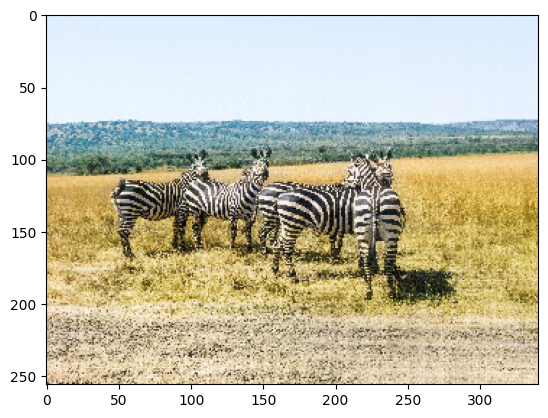

Epoch: 6000, Loss: 0.0025042365305125713


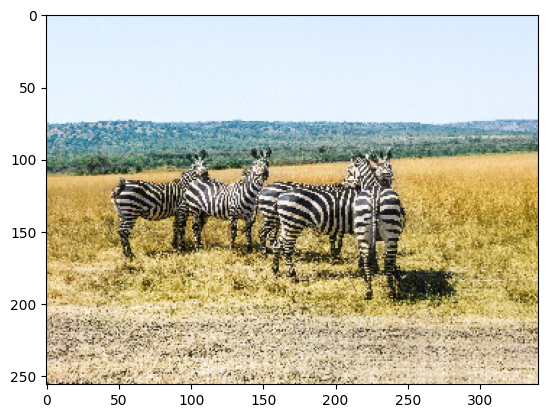

Epoch: 7000, Loss: 0.0015701362863183022


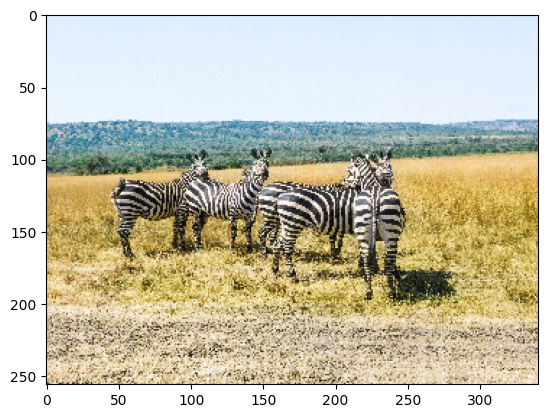

Epoch: 8000, Loss: 0.0012553262058645487


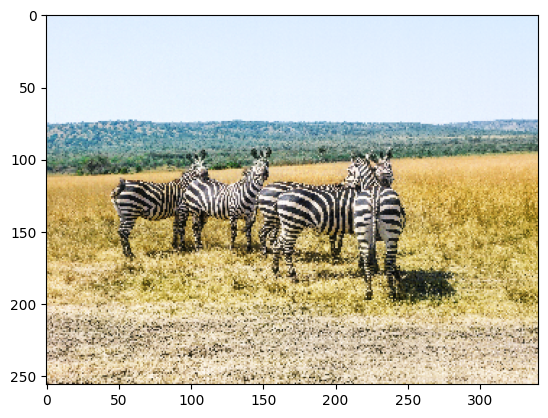

Epoch: 9000, Loss: 0.0012647871626541018


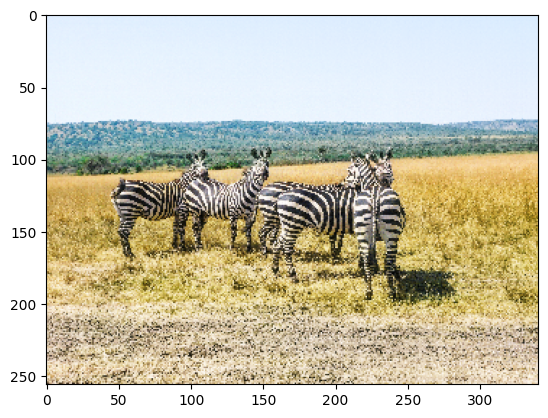

Epoch: 10000, Loss: 0.000991141889244318


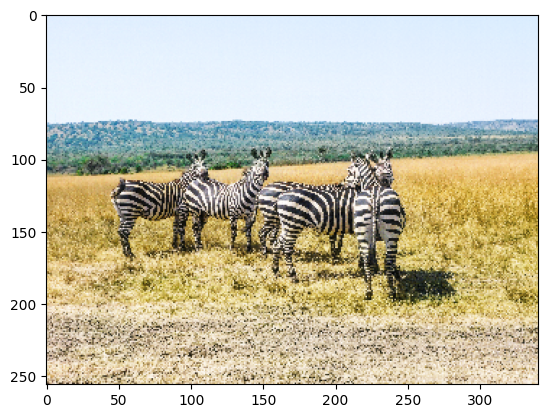

In [ ]:
epochs = 10000
embedded_indices = embedder(indices).to(device)

for epoch in range(epochs):
    optimizer.zero_grad()
    pred_rgbs = model(embedded_indices)
    loss = loss_fn(pred_rgbs, rgbs)
    
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 999 or epoch == 0:
        with torch.no_grad():
            pred_img = pred_rgbs.reshape(img.shape)
            print(f"Epoch: {epoch + 1}, Loss: {loss}")
            plt.imshow(pred_img.cpu())
            plt.show()
